In [50]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import yfinance as yf # type: ignore

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load financial data

In [51]:
data = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [52]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800
1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600


In [53]:
X = data.to_numpy()
X.shape

(11091, 6)

In [54]:
def create_sequence(data: np.ndarray, seq_len: int = 8, target_sequence: bool = False) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        if target_sequence:
            y.append(data[(i+1):(i+1+seq_len)])
        else:
            y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# Split and scale

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_train, X_test = train_test_split(X, test_size=0.2)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (8872, 6), Test: (2219, 6)


# Create sequences

In [56]:
X_train, y_train = create_sequence(X_train, target_sequence=True)
X_test, y_test = create_sequence(X_test, target_sequence=True)

print(f'X, y_train: {X_train.shape} {y_train.shape}')
print(f'X, y_test: {X_test.shape} {y_test.shape}')

X, y_train: (8864, 8, 6) (8864, 8, 6)
X, y_test: (2211, 8, 6) (2211, 8, 6)


# Custom dataset

In [57]:
class StockDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the data and label at the given index.
        
        Args:
            idx (int): The index of the sample to retrieve.
        
        Returns:
            tuple: (data, label)
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Data preparation

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, y_train, y_test = torch.Tensor(X_train), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_test)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [59]:
batch_size = 32

dataset_train = StockDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = StockDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [60]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers=6, hidden_dim=64, dropout=0.1):
        super(TransformerModel, self).__init__()

        #self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        # Define the Transformer model
        self.transformer = nn.Transformer(
            d_model=hidden_dim,    # the dimension of input and output
            nhead=num_heads,       # the number of attention heads
            num_encoder_layers=num_layers,  # number of encoder layers
            num_decoder_layers=num_layers,  # number of decoder layers
            dim_feedforward=hidden_dim * 4,  # feedforward dimension inside the transformer
            dropout=dropout,
            batch_first=True
        )
        
        # Output layer (linear transformation from hidden_dim to output_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, tgt):
        #output = self.fc_in(src)
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

In [61]:
seq_len = 8
n_features = 6  # Number of financial indicators

model = TransformerModel(input_dim=n_features, output_dim=n_features, num_heads=6, hidden_dim=n_features)
model = model.to(device)

In [62]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

model.train()

for epoch in range(100):

    epoch_loss = 0

    for data, target in dataloader_train:
        optimizer.zero_grad()
        output = model(data, target)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader_train)}")

Epoch: 1, Loss: 0.5399732061456687
Epoch: 2, Loss: 0.12883727711084086
Epoch: 3, Loss: 0.0735212061621437
Epoch: 4, Loss: 0.052798211964566785


KeyboardInterrupt: 

In [63]:
model.eval()

with torch.no_grad():

    val_output = model(X_test, y_test)
    val_loss = criterion(val_output, y_test)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.020611751824617386


In [65]:
true_unscaled = scaler_X.inverse_transform(y_test[0].cpu())
predicted_unscaled = scaler_X.inverse_transform(val_output[0].cpu())
print(f'Shapes: {true_unscaled.shape}, {predicted_unscaled.shape}')

Shapes: (8, 6), (8, 6)


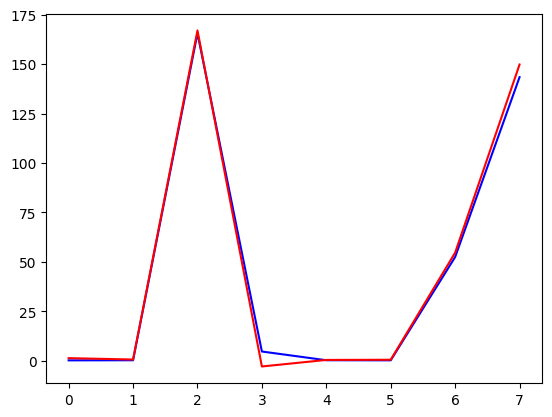

In [67]:
x = [i for i in range(len(true_unscaled))]
plt.plot(x, true_unscaled[:, 0], color='blue')
plt.plot(x,predicted_unscaled[:, 0], color='red')
plt.show()